In [1]:
import pandas as pd
import numpy as np
import os
import re
from decimal import *
# generate random Gaussian values
from numpy.random import seed
from numpy.random import randn,randint
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Calculate sorption parameters 

In [3]:
interval_list = [[[0.59,0.67],[],[0.68,0.72],[0.45,0.55],[0.56,0.58],[],[]], # II
                [[0.340,0.43],[],[0.44,0.47],[0.30,0.33],[0.20,0.29],[0.48,0.55],[0.100,0.200],[0.56,0.700],[0.71,100],[0,0.09]], #III
                [[0.20,0.29],[0.040,0.055],[0.30,0.35],[0.40,0.50],[0,0.19],[]], # V
                [[0.76,0.83],[],[0.40,0.75],[0.84,1.3],[1.4,3.0],[3.1,100],[]], # I
                [[0.561,0.659],[0.27,0.33],[0.66,0.69],[0.70,0.75],[0.50,0.56],[0.34,0.49],[0.76,0.95],[0.96,100],[0,0.26]], # IV               
                [[53,67],[],[40,52],[68,70],[0,39],[71,100],[0,30]], #T
                [[0.22,0.26],[],[0.17,0.21],[0.27,0.30],[0.31,0.43],[0.10,0.16],[0.44,0.55]]] # S(30/60)

In [4]:
def read_data(path_texts):
    return pd.read_excel(path_texts, sheet_name=1, header=0)

In [5]:
def tfg_converter(lines):
    #splitting to title string and numerical data
    title_raw = lines[:8]
    tf_raw = lines[8:170]
    #numerical data list forming
    tf_list = []
    for i in range(len(tf_raw)):
        line = re.sub(r"(?i)[<point time=alue=/>]", "", tf_raw[i])
        tf_str = line.replace('v',' ').replace('"',"").replace(",",".").split()
        tf_num = float(tf_str[1])
        tf_list.append(tf_num)
    #title string forming
    title_str = []
    for i in range(len(title_raw)):
        line = re.sub(r"(?i)[mesure<name></name>dciptiolghk=]", "", title_raw[i])
        ts=line.replace('"',"").replace(",",".").replace('\ufeff',"")
        title_str.append(ts)
    return title_str[1:], tf_list

In [6]:
def parse_covid_tfg(data_path):
    tree = ET.parse(data_path)
    root = tree.getroot()
    tf_arr = []
    meta_info = root.find('name').text
    for point in root.iter('point'):
        tf_arr.append(int(point.attrib['value']))
        
    return meta_info, np.array(tf_arr, dtype=np.float64)


In [7]:
def get_arr(data_path):
    file = open(data_path, encoding='utf-8')
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]
    
    tfg_pred = tfg_converter(lines)
    meta_info = tfg_pred[0]   
    
    tf_arr = np.array(tfg_pred[1])
    tf_arr = tf_arr[0] - tf_arr
    
    file.close()
    
    return meta_info, tf_arr

def get_arr_from_covid_tfg(data_path):
    return parse_covid_tfg(data_path)
    

In [8]:
#interval membership detector
def detect(list, x):
    getcontext().prec = 2
    fl = (x >= Decimal(str(list[0])))
    fr = (x <= Decimal(str(list[1])))
    if fl & fr:
        return 1
    else:
        return 0

In [9]:
#list of active intervals
def ind_tx(feature_intervals, fv):
    candidates = []
    for k in range(len(feature_intervals)):
        ivl = feature_intervals[k]
        if len(ivl) == 0:
            continue
        if detect(ivl, fv) == 1:
            candidates.append(k)
    if len(candidates) == 0:
        return -1
    # in case of nested intervals choose the smallest
    elif len(candidates) > 1:
        sorted_candidates = sorted([feature_intervals[k] for k in candidates], key=lambda tup: tup[1])
        final_candidate = sorted_candidates[0]
        return feature_intervals.index(final_candidate)

    return candidates[0]

In [10]:
def calculate_features(tf_arr):
    # precision installation
    getcontext().prec = 2

    # Noise level
    dev=2
    # seed random number generator
    seed(42)
    # generate some Gaussian values
    tf_arrN = randint(-dev,dev,size=len(tf_arr))+tf_arr    

    def integral_sum(a, b):
        dx = b - a
        y1 = tf_arr[a]
        y2 = tf_arr[b]

        return (y1 + y2) / 2.0 * dx

    def tau_l(ref, arr):
        i=1
        for k in range(60):
            if arr[i] <= ref:
                i=i+1
            else:
                tleft=i-1
                return tleft

    #a(40/60)
    f1 = Decimal(str(tf_arr[40])) / Decimal(str(tf_arr[60]))

    #a(30/60)
    f2 = Decimal(tf_arr[30]) / Decimal(tf_arr[60])

    #a(20/60)
    f3 = Decimal(tf_arr[20]) / Decimal(tf_arr[60])

    #a(40/70)
    f4 = Decimal(tf_arr[40]) / Decimal(tf_arr[70])

    #a(20/30)
    f5 = Decimal(tf_arr[20]) / Decimal(tf_arr[30])

    #T
    with localcontext() as ctx:
        ctx.rounding = ROUND_HALF_UP
        ref = Decimal(np.amax(tf_arr)/2).to_integral_value()
        f6 = tau_l(ref, tf_arr) * 2

    #S(30)/S(60)
    f7 = Decimal(integral_sum(4, 30)) / Decimal(integral_sum(4, 60))

    return [f1, f2, f3, f4, f5, f6, f7]

In [11]:
def collect_output_text(features, interval_list, kuchmagic_table):
    text_out = []
    intervals = []
    text_alarm='out of intervals'
    for i, f in enumerate(features):
        #get index of interval where the value is
        row = ind_tx(interval_list[i], f)
        if row == -1:
            text_out.append(text_alarm)
        else:
            text_out.append(kuchmagic_table.iloc[row][i+1].strip())
        intervals.append(row)
    return text_out, intervals

In [12]:
# get meta info and final list of texts from tfg file
# used for output of text values of parameters
def get_text_from_tfg(data_path, interval_list, kuchmagic_table):
    meta_info = []
    text = []
    features = []
    tf_arr = []

    try:
        meta_info, tf_arr = get_arr(data_path)
    except:
        meta_info, tf_arr = get_arr_from_covid_tfg(data_path)

    text = []
    if tf_arr.size > 0:
        features = calculate_features(tf_arr)
        text, _ = collect_output_text(features, interval_list, kuchmagic_table)

    return meta_info, text, features, tf_arr

In [13]:
data = read_data('kuch_magic.xlsx')

In [14]:
data_files = [f for f in os.listdir("data") if os.path.isfile(os.path.join("data", f))]

In [15]:
# if a measurment is taken on the left hand, only the token with description for left hand will be added to final text
# the same way for the right hand
def parse_left_right(texts):
    new_texts = []
    for text in texts:
        new_text = []
        for token in text.split("/"):
            if any(i for i in['слева', 'справа', 'левая', 'правая'] if i in f) and 'слева и справа' in token:
                continue
            if any(i for i in['слева', 'левая'] if i in f) and \
               any(i for i in['справа', 'правая'] if i in token):
                continue
            if any(i for i in['справа', 'правая'] if i in f) and \
               any(i for i in['слева', 'левая'] if i  in token):
                continue
            new_text.append(token)
        new_texts.append("/".join(new_text))
    return new_texts

In [16]:
raw_corpus = []
meta_infos = []
all_features = []
all_volume = []
file_names = []

for f in data_files:
    meta, texts, feat1, tf_arr = get_text_from_tfg(os.path.join('data', f), interval_list, data)
    if len(texts) > 0:
        new_texts = parse_left_right(texts)
        raw_corpus.append(new_texts)
        meta_infos.append(meta)
        all_features.append(feat1)
        all_volume.append(tf_arr[4:60])
        file_names.append(f)
    
for f in os.listdir("data\delta_progress"):
    _, text, feat2, tf_arr = get_text_from_tfg(os.path.join('data\delta_progress', f), interval_list, data)
    if len(text) > 0:
        new_texts = parse_left_right(texts)
        raw_corpus.append(new_texts) 
        all_features.append(feat2)
        all_volume.append(tf_arr[4:60])
        file_names.append(f)
print(len(raw_corpus))

145


In [17]:
len(data_files)

120

### Calculate health index

In [18]:
health_index_interval = [[[89.5, 100], [80.5, 89.4], [70.0, 80.4], [59.5, 69.9], [54.5, 59.4], [49.5, 54.4], [29.5, 49.4], [10, 29.4]]]

In [19]:
def read_data_health_index(path_texts):
    return pd.read_excel(path_texts, sheet_name=2, header=0)

In [20]:
# get final list of texts and corresponding intervals 
# used for health index calculation
def get_features_and_intervals(data_path, interval_list, kuchmagic_table):
    text = []

    try:
        _, tf_arr = get_arr(data_path)
    except:
        _, tf_arr = get_arr_from_covid_tfg(data_path)

    text = []

    if tf_arr.size > 0:
        features = calculate_features(tf_arr)
        text, intervals = collect_output_text(features, interval_list, kuchmagic_table)

    return features, intervals

In [21]:
def calculate_health_index(data_path, interval_list):

    min_sp = 6.9
    max_sp = 20.2

    factor_map = [[1, 1, 1.5, 1.5, 2, 2.5, 3],
                 [1, 1, 1.5, 1.5, 2, 2, 2.5, 2.5, 2.5, 3],
                 [1, 1, 1.5, 2, 3, 3],
                 [1, 1, 1.5, 1.5, 2, 2.5, 3],
                 [1, 1, 1.5, 1.5, 1.5, 2, 2, 2.5, 3],
                 [1, 1, 1.5, 2, 2, 2.5, 3],
                 [1, 1, 1.5, 1.5, 2, 2.5, 2.5]]

    features, intervals = get_features_and_intervals(data_path, interval_list, data)

    i0, i1, i2, i3, i4, i5, i6 = intervals

    SP = (factor_map[0][i0]*1) + \
         (factor_map[1][i1]*1) + \
         (factor_map[2][i2]*1) + \
         (factor_map[3][i3]*0.9) + \
         (factor_map[4][i4]*1) + \
         (factor_map[5][i5]*1.0) + \
         (factor_map[6][i6]*1)

    norm_result = (SP - min_sp) / (max_sp - min_sp)

    health_index = (1 - norm_result) * 100
    with localcontext() as ctx:
        ctx.prec = 3
        health_index = Decimal(health_index) * Decimal(1.0)

    return health_index

In [22]:
all_index = []

for f in data_files:
    all_index.append(float(calculate_health_index(os.path.join('data', f), interval_list)))
    
for f in os.listdir("data\delta_progress"):
    all_index.append(float(calculate_health_index(os.path.join('data\delta_progress', f), interval_list)))

In [23]:
health_data = read_data_health_index('kuch_magic.xlsx')
health_data

,Unnamed: 0,text
0,0,"Норма / Высокая влажность кожи, жарко, испарин..."
1,1,Норма / Легкая усталость / В проекции органов ...
2,2,"Усталость, слабость. Без причины – обратить вн..."
3,3,"На левой стороне - сильная усталость / Боль, ..."
4,4,Для правой руки или проекции органов ЖКТ - си...
5,5,На левой руке (слева на лице и теле) - высокий...
6,6,На левой руке (слева на лице и теле) - резкий ...
7,7,Срочно принять меры! При норме состояния и нат...


In [24]:
# for i in all_index:
#     print(i, collect_output_text([i], health_index_interval, health_data))

## Сборка датасетов

In [25]:
def make_plot(volume):
    x = list(range(0, len(volume)))
    y = volume
    
    plt.figure(figsize=(10,5), dpi=80)
    plt.grid()
    
    plt.xlabel('time')
    plt.ylabel('frequency')
    plt.plot(x, y)

In [26]:
health_index_interval[0]

[[89.5, 100],
 [80.5, 89.4],
 [70.0, 80.4],
 [59.5, 69.9],
 [54.5, 59.4],
 [49.5, 54.4],
 [29.5, 49.4],
 [10, 29.4]]

In [27]:
all_volume.pop(79)
all_index.pop(79)

66.2

In [28]:
print(len(all_volume))
print(len(all_index))

144
144


In [29]:
num_index = []

for index in all_index:
    for j in range(len(health_index_interval[0])):
        if index >= health_index_interval[0][j][0] and index <= health_index_interval[0][j][1]:
            num_index.append(j)
            break
                     
print(len(num_index))

144


Пробуем разбить на меньшее количество классов

In [30]:
health_index_interval_3 = [[[80.5, 100], [59.5, 80.4], [10, 59.4]]]

num_index_3 = []

for index in all_index:
    for j in range(len(health_index_interval_3[0])):
        if index >= health_index_interval_3[0][j][0] and index <= health_index_interval_3[0][j][1]:
            num_index_3.append(j)
            break

In [31]:
dat_volume = pd.DataFrame(all_volume, columns = list(range(4, 60)))
dat_volume

,4,5,6,7,8,9,10,11,12,13,...,50,51,52,53,54,55,56,57,58,59
0,-2.0,-1.0,2.0,5.0,11.0,16.0,22.0,30.0,38.0,46.0,...,358.0,364.0,370.0,377.0,384.0,390.0,396.0,402.0,407.0,414.0
1,-2.0,0.0,3.0,7.0,13.0,20.0,27.0,34.0,42.0,49.0,...,379.0,387.0,396.0,403.0,410.0,417.0,424.0,430.0,437.0,444.0
2,4.0,10.0,17.0,27.0,38.0,49.0,62.0,75.0,88.0,100.0,...,407.0,412.0,416.0,421.0,424.0,429.0,432.0,436.0,440.0,444.0
3,1.0,2.0,3.0,5.0,5.0,8.0,9.0,11.0,14.0,16.0,...,91.0,93.0,95.0,97.0,99.0,101.0,103.0,104.0,106.0,108.0
4,1.0,2.0,3.0,5.0,8.0,10.0,13.0,15.0,18.0,20.0,...,121.0,123.0,125.0,127.0,130.0,132.0,133.0,136.0,138.0,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,5.0,7.0,9.0,11.0,13.0,16.0,18.0,21.0,23.0,26.0,...,134.0,142.0,150.0,159.0,167.0,177.0,186.0,194.0,203.0,211.0
140,2.0,2.0,2.0,2.0,3.0,4.0,4.0,5.0,5.0,5.0,...,33.0,33.0,33.0,34.0,35.0,35.0,37.0,37.0,38.0,39.0
141,2.0,3.0,3.0,4.0,4.0,5.0,5.0,6.0,6.0,7.0,...,26.0,26.0,27.0,28.0,28.0,28.0,29.0,29.0,30.0,31.0
142,1.0,2.0,2.0,3.0,3.0,4.0,5.0,5.0,6.0,6.0,...,35.0,37.0,37.0,39.0,39.0,41.0,41.0,42.0,43.0,44.0


In [32]:
from collections import Counter
Counter(num_index)

Counter({1: 69, 5: 10, 0: 12, 3: 9, 2: 21, 6: 17, 4: 6})

In [33]:
from collections import Counter
Counter(num_index_3)

Counter({0: 81, 2: 33, 1: 30})

In [34]:
# for i in range(len(num_index)):
#     print(num_index[i], all_index[i])

## Подсчет количества информации

In [35]:
mas_rows = []

for i in range(len(dat_volume)):
    row = np.array(dat_volume.iloc[i])
    mas_rows.append(row)
    
mas_difference = []

for row in mas_rows:
    temp = []
    for i in range(1, len(row)):
        temp.append(row[i]-row[i-1])
    mas_difference.append(temp)

In [36]:
df_diff = pd.DataFrame(data = mas_difference, index = [i for i in range(len(mas_difference))])
df_diff

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,1.0,3.0,3.0,6.0,5.0,6.0,8.0,8.0,8.0,8.0,...,7.0,6.0,6.0,7.0,7.0,6.0,6.0,6.0,5.0,7.0
1,2.0,3.0,4.0,6.0,7.0,7.0,7.0,8.0,7.0,9.0,...,8.0,8.0,9.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0
2,6.0,7.0,10.0,11.0,11.0,13.0,13.0,13.0,12.0,12.0,...,6.0,5.0,4.0,5.0,3.0,5.0,3.0,4.0,4.0,4.0
3,1.0,1.0,2.0,0.0,3.0,1.0,2.0,3.0,2.0,2.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
4,1.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0,...,2.0,2.0,2.0,2.0,3.0,2.0,1.0,3.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2.0,2.0,2.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,...,7.0,8.0,8.0,9.0,8.0,10.0,9.0,8.0,9.0,8.0
140,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,...,2.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0
141,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
142,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,1.0,1.0


(array([ 6., 35., 26., 18.,  6., 10., 12., 11.,  6.,  2.,  4.,  3.,  1.,
         1.,  0.,  0.,  1.,  2.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18.]),
 <BarContainer object of 18 artists>)

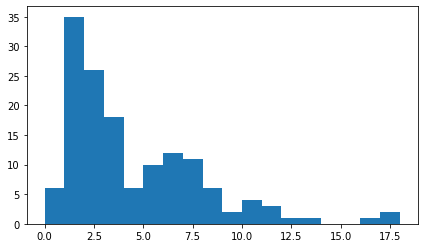

In [37]:
plt.figure(figsize=(7, 4))
plt.hist(df_diff[5], bins = np.arange(min(df_diff[5]), max(df_diff[5]) + 1, 1))  

In [38]:
# plt.figure(figsize=(7, 170))

# for key in df_diff:
#     if key < 54:
#         plt.subplot(54, 1, key+1)
#         plt.hist(df_diff[key], bins = np.arange(min(df_diff[key]), max(df_diff[key]) + 1, 1))   

In [39]:
#вычисляем вероятности

mas_numb = []

for i in mas_difference:
    mas_numb += i
   
cnt = Counter(mas_numb).items()
N = len(mas_numb)
mas_prob = []
S = 0

for i in cnt:
    p = i[1] / N
    mas_prob.append(p * math.log2(p))
    S += p * math.log2(p)

print(N)
print("Количество бит информации = ", -S)
print("Общее количество информации в одной хчг = ", -S *55) #количество бит на цифру умножить на количество колонок

7920
Количество бит информации =  3.9078597479242068
Общее количество информации в одной хчг =  214.93228613583136


Энтропия - косвенный показатель, позволяющий оценить смысловую информативность новости. Энтропия — это количество информации, приходящейся на одно элементарное сообщение источника, вырабатывающего статистически независимые сообщения.

Таким образом, количество информации, которая содержит 1 хчг равна 4 битам. Количество информации вычисляется как произведение энтропии на число символов в тексте. Чем больше это число, тем больше в тексте информации [по Шеннону]. Сравним эти числа с абзацем из Войны и мира.

http://newscad.com/entropy-calculator

In [40]:
#результаты калькулятора с сайта

arr = "Пациент около 15 лет страдает артериальной гипертензией, выявленной случайно при прохождении медицинского осмотра. Выставлялся диагноз гипертоническая болезнь. Регулярно лечение не принимал, только эпизодически. АД рабочим считает 160 и 90 мм.рт. В 2006 г. отмечает стационарное лечение в неврологическом отделении БСМП по поводу гипертонического криза и транзиторного нарушения мозгового кровообращения. Выписан с улучшением: дизартрия и гемианестезия слева исчезли, АД при выписке 130 и 80 мм. рт. ст. Далее принимал энап 5 мг 2 раза в день нерегулярно. Высокое АД не чувствует и самостоятельно не контролирует. В феврале 2007 г. стал отмечать появление давящих болей за грудиной при интенсивной физической нагрузке. За помощью не обращался. Боли купировались в покое. 15 декабря 2008 на фоне обычных нагрузок возникли сильные раздирающие боли за грудиной сопровождавшиеся одышкой смешанного характера и страхом смерти. Бригадой скорой медицинской помощи доставлен в приёмный покой ГК БСМП и госпитализирован в отделение кардиореанимации с дигнозом ИБС кардиогенный шок крупноочаговый инфаркт миокарда."
arr_2 = "Пациент около 15 лет страдает артериальной гипертензией, выявленной случайно при прохождении медицинского осмотра."
print(len(arr))
print(len(arr_2))

1104
114


In [41]:
#калькулятор написанный мной

cnt = Counter(arr).items()
N = len(arr)
mas_prob = []
S = 0

for i in cnt:
    p = i[1] / N
    mas_prob.append(p * math.log2(p))
    S += p * math.log2(p)
    
print(N)    
print("Количество бит информации = ", -S)
print("Общее количество информации в строке = ", -S * len(arr_2))

1104
Количество бит информации =  4.698183362352153
Общее количество информации в строке =  535.5929033081454


## Рассчет погрешностей

**оценка с помощью метода KNN** 

In [519]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [520]:
print(len(dat_volume))
print(len(num_index_3))

144
144


**для 3 классов**

In [521]:
tot_accur = []
tot_recall = []
tot_precis = []
tot_f1 = []
tot_roc_auc = []

n_neighbors = 3
random_state = 0

X = dat_volume
y = num_index_3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

n_classes = len(np.unique(y))

pca = make_pipeline(StandardScaler(), PCA(n_components=1, random_state=random_state))
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=1))
svd = make_pipeline(StandardScaler(), TruncatedSVD(n_components = 1, random_state = 0, algorithm = 'randomized'))
imap = make_pipeline(StandardScaler(), Isomap(n_components = 1, n_neighbors = 50, eigen_solver = 'auto'))
kerpca_cos = make_pipeline(StandardScaler(), KernelPCA(n_components = 1, random_state = 0, kernel='cosine'))
kerpca_poly = make_pipeline(StandardScaler(), KernelPCA(n_components = 1, random_state = 0, kernel='poly'))

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("SVD", svd), 
                         ("ISOMAP", imap), ("Kernal PCA cos", kerpca_cos), ("Kernal PCA poly", kerpca_poly)]

for i, (name, model) in enumerate(dim_reduction_methods):

    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_train), y_train)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(X_test), y_test)

    y_pred = knn.predict(model.transform(X_test))
    y_prob = knn.predict_proba(model.transform(X_test)) #высчитываем вероятности классов для рок аук
    
    print(name, "\n")
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    recall = recall_score(y_test, y_pred, average = 'macro')
    print("Recall:", recall)

    precision = precision_score(y_test, y_pred, average = 'macro')
    print("Precision:", precision)

    f1 = f1_score(y_test, y_pred, average = 'macro')
    print("F1:", f1)

    roc_auc = roc_auc_score(y_test, y_prob, average = 'macro', multi_class="ovo")
    print("ROC AUC:", roc_auc)
    
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred), "\n")
    tot_accur.append(accuracy)
    tot_recall.append(recall)
    tot_precis.append(precision)
    tot_f1.append(f1)
    tot_roc_auc.append(roc_auc)

PCA 

Accuracy: 0.5454545454545454
Recall: 0.32
Precision: 0.20512820512820515
F1: 0.25000000000000006
ROC AUC: 0.5312222222222222
Confusion matrix:
 [[24  0  1]
 [ 7  0  2]
 [ 8  2  0]] 

LDA 

Accuracy: 0.45454545454545453
Recall: 0.4177777777777778
Precision: 0.45031055900621114
F1: 0.4243748223927253
ROC AUC: 0.594925925925926
Confusion matrix:
 [[13  9  3]
 [ 6  3  0]
 [ 4  2  4]] 

SVD 

Accuracy: 0.5454545454545454
Recall: 0.32
Precision: 0.20512820512820515
F1: 0.25000000000000006
ROC AUC: 0.5312222222222222
Confusion matrix:
 [[24  0  1]
 [ 7  0  2]
 [ 8  2  0]] 

ISOMAP 

Accuracy: 0.5909090909090909
Recall: 0.3666666666666667
Precision: 0.3247863247863248
F1: 0.311698717948718
ROC AUC: 0.5342222222222223
Confusion matrix:
 [[25  0  0]
 [ 7  0  2]
 [ 7  2  1]] 

Kernal PCA cos 

Accuracy: 0.5681818181818182
Recall: 0.397037037037037
Precision: 0.3838259441707717
F1: 0.3873456790123457
ROC AUC: 0.6031481481481481
Confusion matrix:
 [[22  2  1]
 [ 3  1  5]
 [ 4  4  2]] 

Kernal

In [522]:
d = {'accur': tot_accur, 'recall': tot_recall, 'precis': tot_precis, 'f1': tot_f1, 'roc_auc': tot_roc_auc}
total_metrics = pd.DataFrame(data = d, index=['PCA', 'LDA', 'SVD', 'ISOMAP', 'Ker_cos', 'Ker_pol'])

In [523]:
total_metrics

,accur,recall,precis,f1,roc_auc
PCA,0.545455,0.320000,0.205128,0.250000,0.531222
LDA,0.454545,0.417778,0.450311,0.424375,0.594926
SVD,0.545455,0.320000,0.205128,0.250000,0.531222
ISOMAP,0.590909,0.366667,0.324786,0.311699,0.534222
Ker_cos,0.568182,0.397037,0.383826,0.387346,0.603148
Ker_pol,0.590909,0.386667,0.343860,0.342857,0.585037


**без стандартизации и нормализации для 3 классов**

In [524]:
tot_accur = []
tot_recall = []
tot_precis = []
tot_f1 = []
tot_roc_auc = []

n_neighbors = 3
random_state = 0

X = dat_volume
y = num_index_3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

n_classes = len(np.unique(y))

pca = make_pipeline(PCA(n_components=1, random_state=random_state))
lda = make_pipeline(LinearDiscriminantAnalysis(n_components=1))
svd = make_pipeline(TruncatedSVD(n_components = 1, random_state = 0, algorithm = 'randomized'))
imap = make_pipeline(Isomap(n_components = 1, n_neighbors = 50, eigen_solver = 'auto'))
kerpca_cos = make_pipeline(KernelPCA(n_components = 1, random_state = 0, kernel='cosine'))
kerpca_poly = make_pipeline(KernelPCA(n_components = 1, random_state = 0, kernel='poly'))

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("SVD", svd), 
                         ("ISOMAP", imap), ("Kernal PCA cos", kerpca_cos), ("Kernal PCA poly", kerpca_poly)]

for i, (name, model) in enumerate(dim_reduction_methods):

    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_train), y_train)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(X_test), y_test)
    y_pred = knn.predict(model.transform(X_test))
    y_prob = knn.predict_proba(model.transform(X_test)) #высчитываем вероятности классов для рок аук
    
    print(name, "\n")
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    recall = recall_score(y_test, y_pred, average = 'macro')
    print("Recall:", recall)

    precision = precision_score(y_test, y_pred, average = 'macro')
    print("Precision:", precision)

    f1 = f1_score(y_test, y_pred, average = 'macro')
    print("F1:", f1)

    roc_auc = roc_auc_score(y_test, y_prob, average = 'macro', multi_class="ovo")
    print("ROC AUC:", roc_auc)
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred), "\n")
    
    tot_accur.append(accuracy)
    tot_recall.append(recall)
    tot_precis.append(precision)
    tot_f1.append(f1)
    tot_roc_auc.append(roc_auc)    

PCA 

Accuracy: 0.5227272727272727
Recall: 0.3940740740740741
Precision: 0.42096774193548386
F1: 0.3955026455026455
ROC AUC: 0.6622962962962963
Confusion matrix:
 [[19  2  4]
 [ 5  2  2]
 [ 7  1  2]] 

LDA 

Accuracy: 0.45454545454545453
Recall: 0.4177777777777778
Precision: 0.45031055900621114
F1: 0.4243748223927253
ROC AUC: 0.594925925925926
Confusion matrix:
 [[13  9  3]
 [ 6  3  0]
 [ 4  2  4]] 

SVD 

Accuracy: 0.5454545454545454
Recall: 0.4074074074074074
Precision: 0.43690476190476185
F1: 0.4075875964420856
ROC AUC: 0.6491851851851852
Confusion matrix:
 [[20  2  3]
 [ 5  2  2]
 [ 7  1  2]] 

ISOMAP 

Accuracy: 0.5227272727272727
Recall: 0.3940740740740741
Precision: 0.42096774193548386
F1: 0.3955026455026455
ROC AUC: 0.6622962962962963
Confusion matrix:
 [[19  2  4]
 [ 5  2  2]
 [ 7  1  2]] 

Kernal PCA cos 

Accuracy: 0.7954545454545454
Recall: 0.7214814814814815
Precision: 0.7738095238095237
F1: 0.7424672174949644
ROC AUC: 0.848037037037037
Confusion matrix:
 [[23  2  0]
 [ 5 

In [525]:
d = {'accur': tot_accur, 'recall': tot_recall, 'precis': tot_precis, 'f1': tot_f1, 'roc_auc': tot_roc_auc}
total_metrics = pd.DataFrame(data = d, index=['PCA', 'LDA', 'SVD', 'ISOMAP', 'Ker_cos', 'Ker_pol'])

In [526]:
total_metrics

,accur,recall,precis,f1,roc_auc
PCA,0.522727,0.394074,0.420968,0.395503,0.662296
LDA,0.454545,0.417778,0.450311,0.424375,0.594926
SVD,0.545455,0.407407,0.436905,0.407588,0.649185
ISOMAP,0.522727,0.394074,0.420968,0.395503,0.662296
Ker_cos,0.795455,0.721481,0.773810,0.742467,0.848037
Ker_pol,0.477273,0.300000,0.243697,0.265204,0.600778


### KNeighborsClassifier 

In [527]:
tot_accur = []
tot_recall = []
tot_precis = []
tot_f1 = []
tot_roc_auc = []

In [528]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, roc_auc_score

In [529]:
X_train, X_test, y_train, y_test = train_test_split(dat_volume, num_index_3, stratify=num_index_3, test_size = 0.3, random_state = 0)

In [530]:
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test) #высчитываем вероятности классов для рок аук

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

recall = recall_score(y_test, y_pred, average = 'macro')
print("Recall:", recall)

precision = precision_score(y_test, y_pred, average = 'macro')
print("Precision:", precision)

f1 = f1_score(y_test, y_pred, average = 'macro')
print("F1:", f1)

roc_auc = roc_auc_score(y_test, y_prob, average = 'macro', multi_class="ovo")
print("ROC AUC:", roc_auc)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

tot_accur.append(accuracy)
tot_recall.append(recall)
tot_precis.append(precision)
tot_f1.append(f1)
tot_roc_auc.append(roc_auc)

Accuracy: 0.5681818181818182
Recall: 0.3333333333333333
Precision: 0.18939393939393942
F1: 0.24154589371980675
ROC AUC: 0.6396666666666667
Confusion matrix:
 [[25  0  0]
 [ 9  0  0]
 [10  0  0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.72        25
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        10

    accuracy                           0.57        44
   macro avg       0.19      0.33      0.24        44
weighted avg       0.32      0.57      0.41        44



### LogisticRegression

In [531]:
logreg = LogisticRegression(multi_class='ovr', random_state = 0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test) #высчитываем вероятности классов для рок аук

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

recall = recall_score(y_test, y_pred, average = 'macro')
print("Recall:", recall)

precision = precision_score(y_test, y_pred, average = 'macro')
print("Precision:", precision)

f1 = f1_score(y_test, y_pred, average = 'macro')
print("F1:", f1)

roc_auc = roc_auc_score(y_test, y_prob, average = 'macro', multi_class="ovr")
print("ROC AUC:", roc_auc)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

tot_accur.append(accuracy)
tot_recall.append(recall)
tot_precis.append(precision)
tot_f1.append(f1)
tot_roc_auc.append(roc_auc)

Accuracy: 0.4772727272727273
Recall: 0.3
Precision: 0.24369747899159666
F1: 0.2652043868394816
ROC AUC: 0.4626741690828378
Confusion matrix:
 [[20  1  4]
 [ 7  0  2]
 [ 7  2  1]]
              precision    recall  f1-score   support

           0       0.59      0.80      0.68        25
           1       0.00      0.00      0.00         9
           2       0.14      0.10      0.12        10

    accuracy                           0.48        44
   macro avg       0.24      0.30      0.27        44
weighted avg       0.37      0.48      0.41        44



### Random Forest

In [532]:
decision_param = {
    "n_estimators": range(5, 100, 5),
    "criterion": ['gini', "entropy"],
    "max_depth": range(1, 15),
    "min_samples_split": range(2, 20),
    "max_features": ['log2', 'sqrt'],
}
grid = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=0), param_distributions=decision_param, n_iter = 100, cv = 5, random_state = 0)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

recall = recall_score(y_test, y_pred, average = 'macro')
print("Recall:", recall)

precision = precision_score(y_test, y_pred, average = 'macro')
print("Precision:", precision)

f1 = f1_score(y_test, y_pred, average = 'macro')
print("F1:", f1)

roc_auc = roc_auc_score(y_test, y_prob, average = 'macro', multi_class="ovo")
print("ROC AUC:", roc_auc)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

tot_accur.append(accuracy)
tot_recall.append(recall)
tot_precis.append(precision)
tot_f1.append(f1)
tot_roc_auc.append(roc_auc)

Accuracy: 0.6818181818181818
Recall: 0.5274074074074074
Precision: 0.6241830065359477
F1: 0.5404172099087353
ROC AUC: 0.7061851851851854
Confusion matrix:
 [[24  1  0]
 [ 5  2  2]
 [ 5  1  4]]
              precision    recall  f1-score   support

           0       0.71      0.96      0.81        25
           1       0.50      0.22      0.31         9
           2       0.67      0.40      0.50        10

    accuracy                           0.68        44
   macro avg       0.62      0.53      0.54        44
weighted avg       0.65      0.68      0.64        44



In [533]:
#grid.best_params_

### DecisionTreeClassifier

In [534]:
decision_param = {
    "criterion": ['gini', "entropy"],
    "max_depth": range(1, 15),
    "min_samples_split": range(2, 20),
    "max_features": ['log2', 'sqrt'],
}
grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), param_grid=decision_param, cv = 5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

In [535]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'min_samples_split': 4}

In [536]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

recall = recall_score(y_test, y_pred, average = 'macro')
print("Recall:", recall)

precision = precision_score(y_test, y_pred, average = 'macro')
print("Precision:", precision)

f1 = f1_score(y_test, y_pred, average = 'macro')
print("F1:", f1)

roc_auc = roc_auc_score(y_test, y_prob, average = 'macro', multi_class="ovo")
print("ROC AUC:", roc_auc)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5454545454545454
Recall: 0.36000000000000004
Precision: 0.3428571428571428
F1: 0.3333333333333333
ROC AUC: 0.5733333333333334
Confusion matrix:
 [[22  3  0]
 [ 6  0  3]
 [ 7  1  2]]
              precision    recall  f1-score   support

           0       0.63      0.88      0.73        25
           1       0.00      0.00      0.00         9
           2       0.40      0.20      0.27        10

    accuracy                           0.55        44
   macro avg       0.34      0.36      0.33        44
weighted avg       0.45      0.55      0.48        44



In [537]:
tot_accur.append(accuracy)
tot_recall.append(recall)
tot_precis.append(precision)
tot_f1.append(f1)
tot_roc_auc.append(roc_auc)

### SVC

In [538]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

In [539]:
decision_param = {
    "n_estimators": range(5, 50, 5)
}
grid = GridSearchCV(estimator=BaggingClassifier(base_estimator=LinearSVC(C = 1, loss = 'squared_hinge', random_state=0, dual=False)), param_grid=decision_param, cv = 5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

In [540]:
grid.best_params_

{'n_estimators': 40}

In [541]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

recall = recall_score(y_test, y_pred, average = 'macro')
print("Recall:", recall)

precision = precision_score(y_test, y_pred, average = 'macro')
print("Precision:", precision)

f1 = f1_score(y_test, y_pred, average = 'macro')
print("F1:", f1)

roc_auc = roc_auc_score(y_test, y_prob, average = 'macro', multi_class="ovo")
print("ROC AUC:", roc_auc)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

tot_accur.append(accuracy)
tot_recall.append(recall)
tot_precis.append(precision)
tot_f1.append(f1)
tot_roc_auc.append(roc_auc)

Accuracy: 0.45454545454545453
Recall: 0.33037037037037037
Precision: 0.34375
F1: 0.3266081871345029
ROC AUC: 0.4887777777777778
Confusion matrix:
 [[17  4  4]
 [ 8  1  0]
 [ 7  1  2]]
              precision    recall  f1-score   support

           0       0.53      0.68      0.60        25
           1       0.17      0.11      0.13         9
           2       0.33      0.20      0.25        10

    accuracy                           0.45        44
   macro avg       0.34      0.33      0.33        44
weighted avg       0.41      0.45      0.42        44



### GaussianNB

In [542]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
y_prob = gnb.predict_proba(X_test) #высчитываем вероятности классов для рок аук

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

recall = recall_score(y_test, y_pred, average = 'macro')
print("Recall:", recall)

precision = precision_score(y_test, y_pred, average = 'macro')
print("Precision:", precision)

f1 = f1_score(y_test, y_pred, average = 'macro')
print("F1:", f1)

roc_auc = roc_auc_score(y_test, y_prob, average = 'macro', multi_class="ovo")
print("ROC AUC:", roc_auc)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

tot_accur.append(accuracy)
tot_recall.append(recall)
tot_precis.append(precision)
tot_f1.append(f1)
tot_roc_auc.append(roc_auc)

Accuracy: 0.5227272727272727
Recall: 0.41037037037037044
Precision: 0.4259259259259259
F1: 0.41595441595441596
ROC AUC: 0.6276666666666667
Confusion matrix:
 [[18  6  1]
 [ 5  1  3]
 [ 4  2  4]]
              precision    recall  f1-score   support

           0       0.67      0.72      0.69        25
           1       0.11      0.11      0.11         9
           2       0.50      0.40      0.44        10

    accuracy                           0.52        44
   macro avg       0.43      0.41      0.42        44
weighted avg       0.52      0.52      0.52        44



### LDA

In [543]:
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
y_prob = lda.predict_proba(X_test) #высчитываем вероятности классов для рок аук

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

recall = recall_score(y_test, y_pred, average = 'macro')
print("Recall:", recall)

precision = precision_score(y_test, y_pred, average = 'macro')
print("Precision:", precision)

f1 = f1_score(y_test, y_pred, average = 'macro')
print("F1:", f1)

roc_auc = roc_auc_score(y_test, y_prob, average = 'macro', multi_class="ovr")
print("ROC AUC:", roc_auc)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

tot_accur.append(accuracy)
tot_recall.append(recall)
tot_precis.append(precision)
tot_f1.append(f1)
tot_roc_auc.append(roc_auc)

Accuracy: 0.4772727272727273
Recall: 0.40740740740740744
Precision: 0.5732600732600732
F1: 0.44452563634149317
ROC AUC: 0.5472793093845726
Confusion matrix:
 [[15 10  0]
 [ 7  2  0]
 [ 4  2  4]]
              precision    recall  f1-score   support

           0       0.58      0.60      0.59        25
           1       0.14      0.22      0.17         9
           2       1.00      0.40      0.57        10

    accuracy                           0.48        44
   macro avg       0.57      0.41      0.44        44
weighted avg       0.58      0.48      0.50        44



### CatBoostClassifier

In [544]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=150, random_seed=0, loss_function='MultiClass', learning_rate=0.15)
model.fit(X_train, y_train, verbose=False)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test) #высчитываем вероятности классов для рок аук

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

recall = recall_score(y_test, y_pred, average = 'macro')
print("Recall:", recall)

precision = precision_score(y_test, y_pred, average = 'macro')
print("Precision:", precision)

f1 = f1_score(y_test, y_pred, average = 'macro')
print("F1:", f1)

roc_auc = roc_auc_score(y_test, y_prob, average = 'macro', multi_class="ovr")
print("ROC AUC:", roc_auc)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

tot_accur.append(accuracy)
tot_recall.append(recall)
tot_precis.append(precision)
tot_f1.append(f1)
tot_roc_auc.append(roc_auc)

Accuracy: 0.6590909090909091
Recall: 0.49037037037037035
Precision: 0.5368814192343604
F1: 0.4836047413315609
ROC AUC: 0.6949800973020787
Confusion matrix:
 [[24  1  0]
 [ 5  1  3]
 [ 5  1  4]]
              precision    recall  f1-score   support

           0       0.71      0.96      0.81        25
           1       0.33      0.11      0.17         9
           2       0.57      0.40      0.47        10

    accuracy                           0.66        44
   macro avg       0.54      0.49      0.48        44
weighted avg       0.60      0.66      0.60        44



### MLPClassifier

In [545]:
param_grid = [
        {
            'activation' : ['identity', 'logistic', 'tanh', 'relu'],
            'solver' : ['sgd', 'adam'],
            'hidden_layer_sizes': [
             (1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,), (12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,)
             ]
        }
       ]

clf = GridSearchCV(MLPClassifier(random_state = 0, max_iter=1000), param_grid, cv=3)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'activation': 'relu', 'hidden_layer_sizes': (15,), 'solver': 'adam'}


In [546]:
#{'activation': 'logistic', 'hidden_layer_sizes': (9,), 'solver': 'adam'}

In [547]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test) #высчитываем вероятности классов для рок аук

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

recall = recall_score(y_test, y_pred, average = 'macro')
print("Recall:", recall)

precision = precision_score(y_test, y_pred, average = 'macro')
print("Precision:", precision)

f1 = f1_score(y_test, y_pred, average = 'macro')
print("F1:", f1)

roc_auc = roc_auc_score(y_test, y_prob, average = 'macro', multi_class="ovr")
print("ROC AUC:", roc_auc)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

tot_accur.append(accuracy)
tot_recall.append(recall)
tot_precis.append(precision)
tot_f1.append(f1)
tot_roc_auc.append(roc_auc)

Accuracy: 0.5227272727272727
Recall: 0.3977777777777778
Precision: 0.41422466422466425
F1: 0.38118485288296605
ROC AUC: 0.5671205792258425
Confusion matrix:
 [[19  6  0]
 [ 4  3  2]
 [ 5  4  1]]
              precision    recall  f1-score   support

           0       0.68      0.76      0.72        25
           1       0.23      0.33      0.27         9
           2       0.33      0.10      0.15        10

    accuracy                           0.52        44
   macro avg       0.41      0.40      0.38        44
weighted avg       0.51      0.52      0.50        44



### Анализ результатов

In [548]:
d = {'accur': tot_accur, 'recall': tot_recall, 'precis': tot_precis, 'f1': tot_f1, 'roc_auc': tot_roc_auc}
total_metrics = pd.DataFrame(data = d, index=['KNN', 'LogReg', 'RandFor', 'DecTree', 'SVC', 'GausNB', 'LDA', 'CatBoostClassifier', 'MLPClassifier'])

In [549]:
total_metrics

,accur,recall,precis,f1,roc_auc
KNN,0.568182,0.333333,0.189394,0.241546,0.639667
LogReg,0.477273,0.300000,0.243697,0.265204,0.462674
RandFor,0.681818,0.527407,0.624183,0.540417,0.706185
DecTree,0.545455,0.360000,0.342857,0.333333,0.573333
SVC,0.454545,0.330370,0.343750,0.326608,0.488778
GausNB,0.522727,0.410370,0.425926,0.415954,0.627667
LDA,0.477273,0.407407,0.573260,0.444526,0.547279
CatBoostClassifier,0.659091,0.490370,0.536881,0.483605,0.694980
MLPClassifier,0.522727,0.397778,0.414225,0.381185,0.567121


In [550]:
sns.set(rc={'figure.figsize':(10,5)})

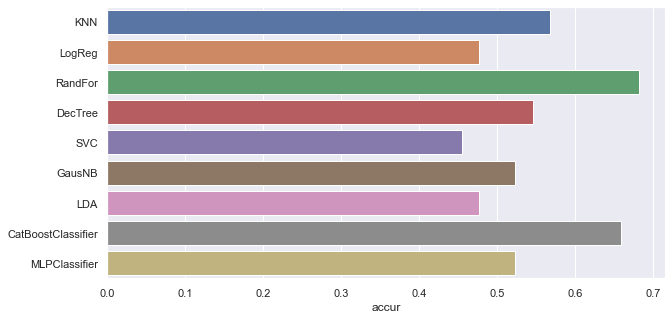

In [551]:
#accuracy

ax = sns.barplot(x="accur", y = total_metrics.index, data=total_metrics)

<AxesSubplot:xlabel='roc_auc'>

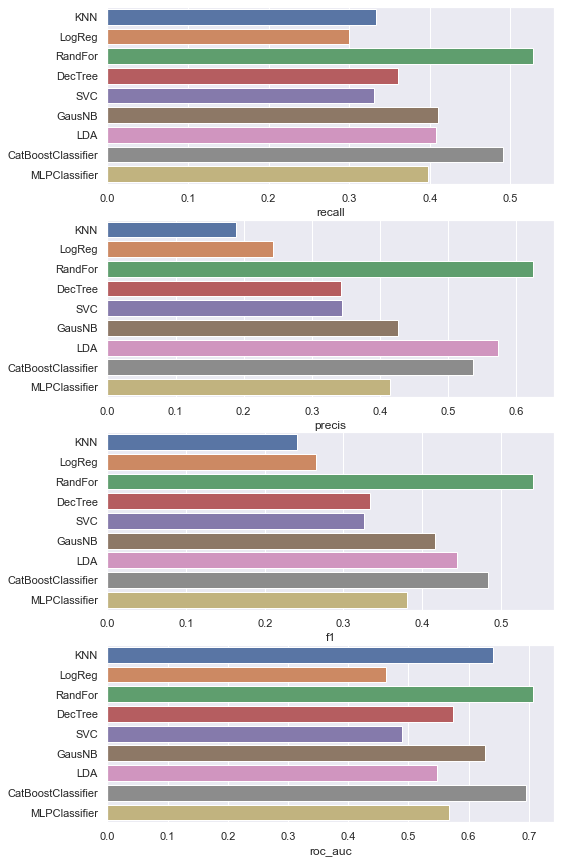

In [552]:
#графики recall precis f1 roc_auc

sns.set(rc={'figure.figsize':(8,15)})
fig, ax = plt.subplots(4,1)
sns.barplot(x="recall", y = total_metrics.index, data=total_metrics, ax = ax[0])
sns.barplot(x="precis", y = total_metrics.index, data=total_metrics, ax = ax[1])
sns.barplot(x="f1", y = total_metrics.index, data=total_metrics, ax = ax[2])
sns.barplot(x="roc_auc", y = total_metrics.index, data=total_metrics, ax = ax[3])

## Комбинирование методов уменьшения размерности и классификации

In [553]:
def calc_metrics(X_embedded):
    tot_accur = []
    tot_recall = []
    tot_precis = []
    tot_f1 = []
    tot_roc_auc = []
    
    X_train, X_test, y_train, y_test = train_test_split(X_embedded, num_index_3, stratify=num_index_3, test_size = 0.3, random_state = 0)
    
    knn = KNeighborsClassifier(n_neighbors=4)
    
    logreg = LogisticRegression(multi_class='ovr', random_state = 0)
    
    decision_param_1 = {
        "n_estimators": range(5, 100, 5),
        "criterion": ['gini', "entropy"],
        "max_depth": range(1, 15),
        "min_samples_split": range(2, 20),
        "max_features": ['log2', 'sqrt'],
    }
    rnd_for = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=decision_param_1, n_iter = 100, cv = 5, random_state = 0)

    decision_param_2 = {
        "criterion": ['gini', "entropy"],
        "max_depth": range(1, 15),
        "min_samples_split": range(2, 20),
        "max_features": ['log2', 'sqrt'],
    }
    des_tree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), param_grid=decision_param_2, cv = 5)
    
    decision_param_3 = {
        "n_estimators": range(5, 50, 5)
    }    
    lin_svc = GridSearchCV(estimator=BaggingClassifier(base_estimator=LinearSVC(C = 1, loss = 'squared_hinge', random_state=0, dual=False)), param_grid=decision_param_3, cv = 5)
    
    gnb = GaussianNB()
    
    lda = LinearDiscriminantAnalysis(solver='svd')
    
    cat = CatBoostClassifier(iterations=150, random_seed=0, loss_function='MultiClass', learning_rate=0.15)

    decision_param_4 = [
            {
                'activation' : ['identity', 'logistic', 'tanh', 'relu'],
                'solver' : ['sgd', 'adam'],
                'hidden_layer_sizes': [
                 (1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,), (12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,)
                 ]
            }
           ]
    mlp = GridSearchCV(MLPClassifier(random_state = 0, max_iter=1000), decision_param_4, cv=3)
    
    mas_models = [[knn, "Knn"], [logreg, "logred"], [rnd_for, "rnd_for"], [des_tree, "des_tree"], [lin_svc, "lin_svc"], [gnb, "gnb"], [lda, "lda"], [cat, "cat"], [mlp, "mlp"]]
    
    
    for model in mas_models:
        
        if model[1] == 'cat':
            model[0].fit(X_train, y_train, verbose=False)
        else:
            model[0].fit(X_train, y_train)
            
        y_pred = model[0].predict(X_test)
        y_prob = model[0].predict_proba(X_test) #высчитываем вероятности классов для рок аук

        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average = 'macro')
        precision = precision_score(y_test, y_pred, average = 'macro')
        f1 = f1_score(y_test, y_pred, average = 'macro')
        roc_auc = roc_auc_score(y_test, y_prob, average = 'macro', multi_class="ovo")

        tot_accur.append(accuracy)
        tot_recall.append(recall)
        tot_precis.append(precision)
        tot_f1.append(f1)
        tot_roc_auc.append(roc_auc)
        print(model[1], "is ready")
    
    d = {'accur': tot_accur, 'recall': tot_recall, 'precis': tot_precis, 'f1': tot_f1, 'roc_auc': tot_roc_auc}
    total_metrics = pd.DataFrame(data = d, index=['KNN', 'LogReg', 'RandFor', 'DecTree', 'SVC', 'GausNB', 'LDA', 'CatBoostClassifier', 'MLPClassifier'])
    return(total_metrics)

### Использование SVD

In [554]:
colors = ["#20C706", "#FBFF1A", "#F05729"]
colors_scatter = [sns.color_palette(colors)[x] for x in num_index_3]
sns.color_palette(colors)

[(0.12549019607843137, 0.7803921568627451, 0.023529411764705882),
 (0.984313725490196, 1.0, 0.10196078431372549),
 (0.9411764705882353, 0.3411764705882353, 0.1607843137254902)]

In [555]:
from sklearn.decomposition import TruncatedSVD

<AxesSubplot:>

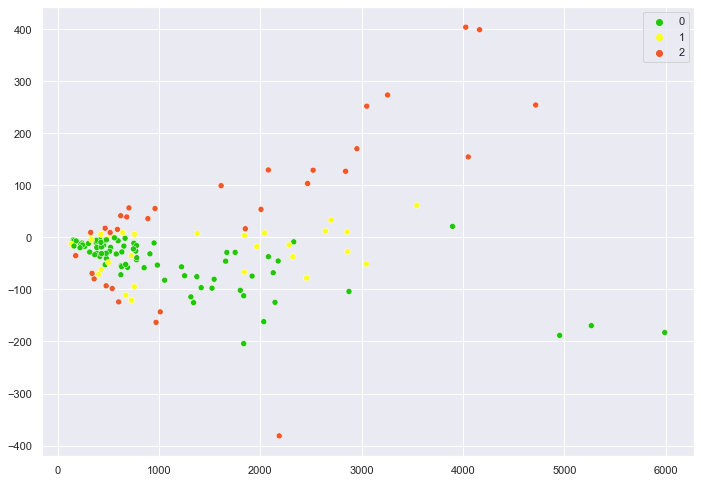

In [556]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

X_embedded = TruncatedSVD(n_components = 2, random_state = 0, algorithm = 'randomized').fit_transform(dat_volume)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = num_index_3, palette = sns.color_palette(colors))

In [557]:
total_metrics_svd = calc_metrics(X_embedded)
total_metrics_svd

Knn is ready
logred is ready
rnd_for is ready
des_tree is ready
lin_svc is ready
gnb is ready
lda is ready
cat is ready
mlp is ready


,accur,recall,precis,f1,roc_auc
KNN,0.659091,0.497778,0.644444,0.507716,0.686444
LogReg,0.659091,0.466667,0.541667,0.446886,0.749556
RandFor,0.772727,0.688148,0.746511,0.709877,0.877963
DecTree,0.772727,0.711852,0.748457,0.726496,0.783889
SVC,0.636364,0.433333,0.536585,0.406371,0.660963
GausNB,0.659091,0.486667,0.488304,0.462302,0.845111
LDA,0.636364,0.433333,0.536585,0.406371,0.794519
CatBoostClassifier,0.795455,0.768889,0.802564,0.781332,0.867704
MLPClassifier,0.840909,0.744444,0.810084,0.748202,0.887778


<AxesSubplot:xlabel='roc_auc'>

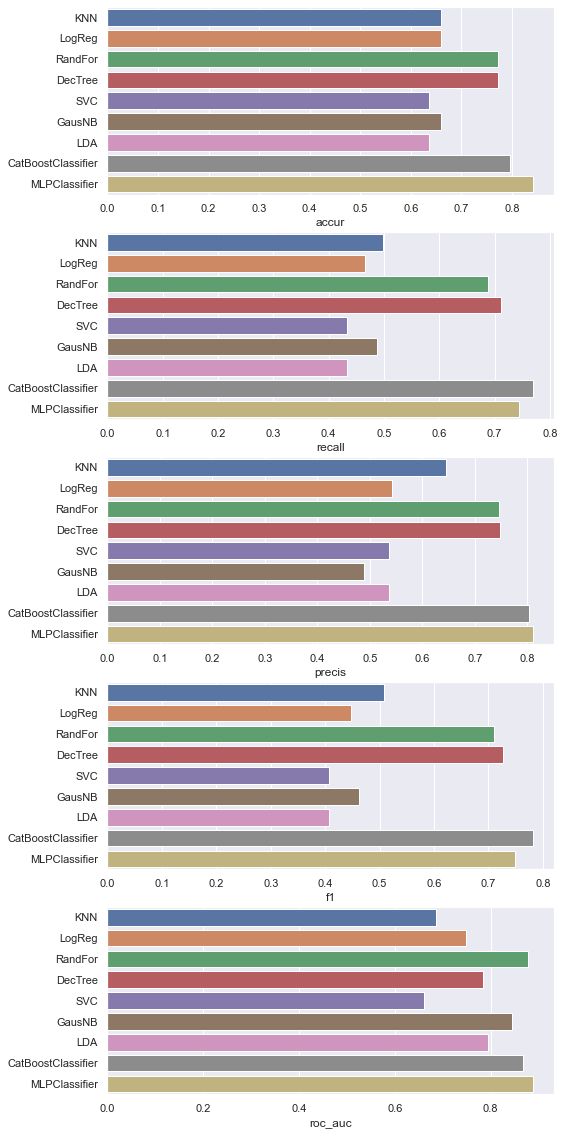

In [558]:
#графики accur recall precis f1 roc_auc

sns.set(rc={'figure.figsize':(8,20)})
fig, ax = plt.subplots(5,1)
sns.barplot(x="accur", y = total_metrics_svd.index, data=total_metrics_svd, ax = ax[0])
sns.barplot(x="recall", y = total_metrics_svd.index, data=total_metrics_svd, ax = ax[1])
sns.barplot(x="precis", y = total_metrics_svd.index, data=total_metrics_svd, ax = ax[2])
sns.barplot(x="f1", y = total_metrics_svd.index, data=total_metrics_svd, ax = ax[3])
sns.barplot(x="roc_auc", y = total_metrics_svd.index, data=total_metrics_svd, ax = ax[4])

### KernelPCA poly

In [559]:
from sklearn.decomposition import KernelPCA

<AxesSubplot:>

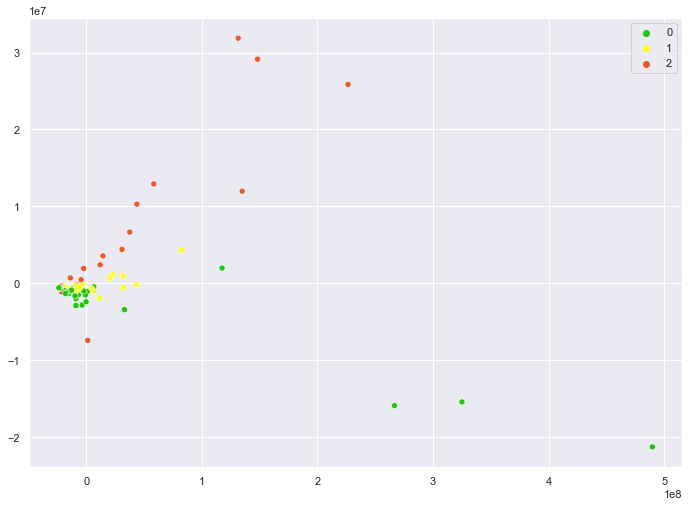

In [560]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

X_embedded = KernelPCA(n_components = 2, random_state = 0, kernel='poly').fit_transform(dat_volume)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = num_index_3, palette = sns.color_palette(colors))

In [561]:
total_metrics_kernel_poly = calc_metrics(X_embedded)
total_metrics_kernel_poly

Knn is ready
logred is ready
rnd_for is ready
des_tree is ready
lin_svc is ready
gnb is ready
lda is ready
cat is ready
mlp is ready


,accur,recall,precis,f1,roc_auc
KNN,0.636364,0.480741,0.607937,0.491667,0.691593
LogReg,0.659091,0.466667,0.441520,0.431217,0.707852
RandFor,0.727273,0.586667,0.457143,0.513131,0.805259
DecTree,0.727273,0.586667,0.457143,0.513131,0.712593
SVC,0.659091,0.466667,0.441520,0.431217,0.689037
GausNB,0.250000,0.400000,0.299145,0.227564,0.612667
LDA,0.613636,0.400000,0.531746,0.359867,0.670000
CatBoostClassifier,0.704545,0.584444,0.607143,0.592140,0.803704
MLPClassifier,0.659091,0.490370,0.611111,0.489568,0.664370


<AxesSubplot:xlabel='roc_auc'>

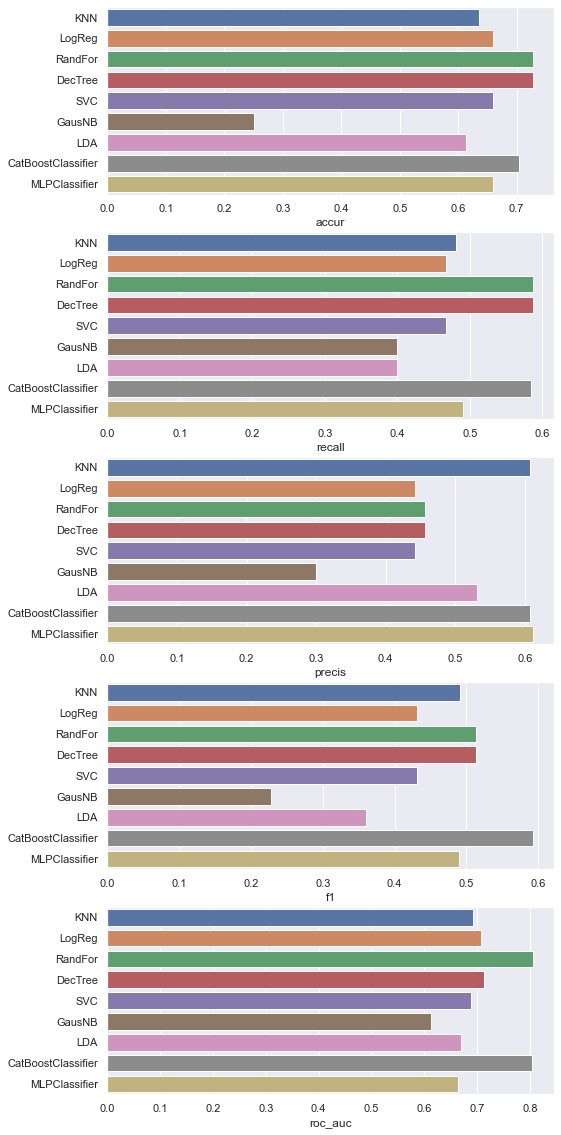

In [562]:
#графики accur recall precis f1 roc_auc

sns.set(rc={'figure.figsize':(8,20)})
fig, ax = plt.subplots(5,1)
sns.barplot(x="accur", y = total_metrics_kernel_poly.index, data=total_metrics_kernel_poly, ax = ax[0])
sns.barplot(x="recall", y = total_metrics_kernel_poly.index, data=total_metrics_kernel_poly, ax = ax[1])
sns.barplot(x="precis", y = total_metrics_kernel_poly.index, data=total_metrics_kernel_poly, ax = ax[2])
sns.barplot(x="f1", y = total_metrics_kernel_poly.index, data=total_metrics_kernel_poly, ax = ax[3])
sns.barplot(x="roc_auc", y = total_metrics_kernel_poly.index, data=total_metrics_kernel_poly, ax = ax[4])

### KernelPCA cosine

<AxesSubplot:>

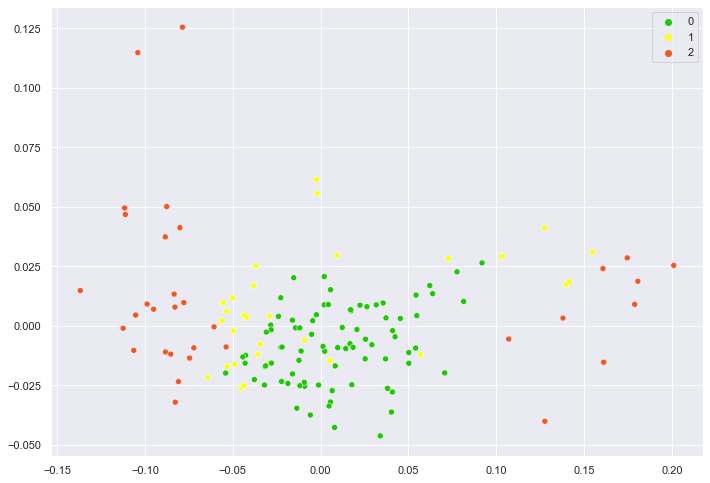

In [563]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

X_embedded = KernelPCA(n_components = 2, random_state = 0, kernel='cosine').fit_transform(dat_volume)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = num_index_3, palette = sns.color_palette(colors))

In [564]:
total_metrics_kernel_cosine = calc_metrics(X_embedded)
total_metrics_kernel_cosine

Knn is ready
logred is ready
rnd_for is ready
des_tree is ready
lin_svc is ready
gnb is ready
lda is ready
cat is ready
mlp is ready


,accur,recall,precis,f1,roc_auc
KNN,0.818182,0.714815,0.801587,0.744207,0.822037
LogReg,0.568182,0.333333,0.189394,0.241546,0.633926
RandFor,0.795455,0.721481,0.760582,0.736677,0.847222
DecTree,0.727273,0.681481,0.721212,0.696296,0.821111
SVC,0.568182,0.333333,0.189394,0.241546,0.525000
GausNB,0.704545,0.560741,0.701961,0.588647,0.735926
LDA,0.568182,0.353333,0.306233,0.293706,0.494296
CatBoostClassifier,0.750000,0.714815,0.711111,0.712460,0.825333
MLPClassifier,0.568182,0.333333,0.189394,0.241546,0.634444


<AxesSubplot:xlabel='roc_auc'>

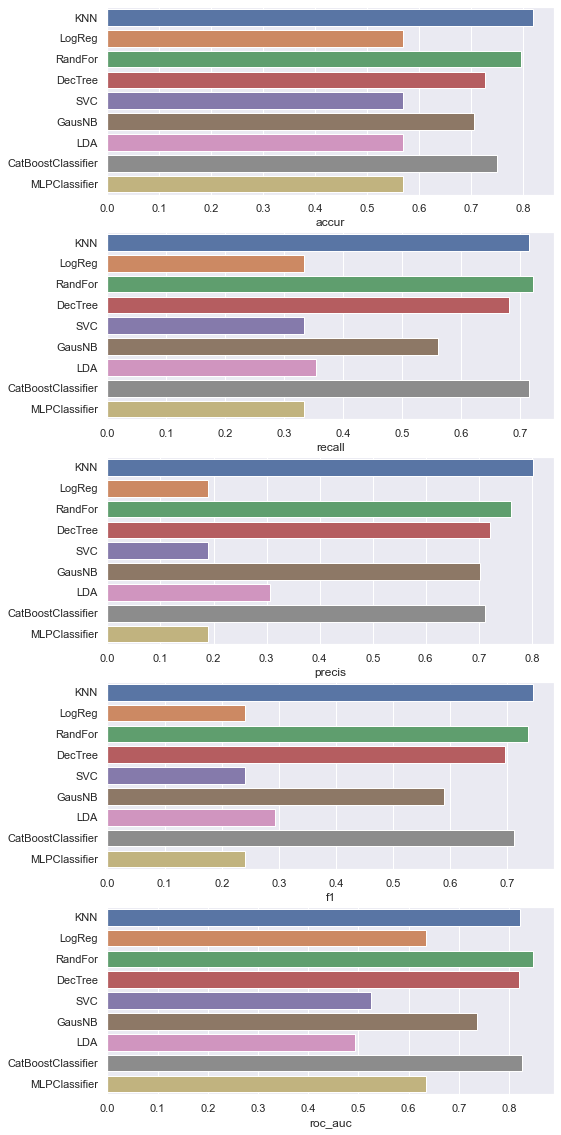

In [565]:
#графики accur recall precis f1 roc_auc

sns.set(rc={'figure.figsize':(8,20)})
fig, ax = plt.subplots(5,1)
sns.barplot(x="accur", y = total_metrics_kernel_cosine.index, data=total_metrics_kernel_cosine, ax = ax[0])
sns.barplot(x="recall", y = total_metrics_kernel_cosine.index, data=total_metrics_kernel_cosine, ax = ax[1])
sns.barplot(x="precis", y = total_metrics_kernel_cosine.index, data=total_metrics_kernel_cosine, ax = ax[2])
sns.barplot(x="f1", y = total_metrics_kernel_cosine.index, data=total_metrics_kernel_cosine, ax = ax[3])
sns.barplot(x="roc_auc", y = total_metrics_kernel_cosine.index, data=total_metrics_kernel_cosine, ax = ax[4])

### ISOMAP 40 соседей

In [566]:
from sklearn.manifold import Isomap

<AxesSubplot:>

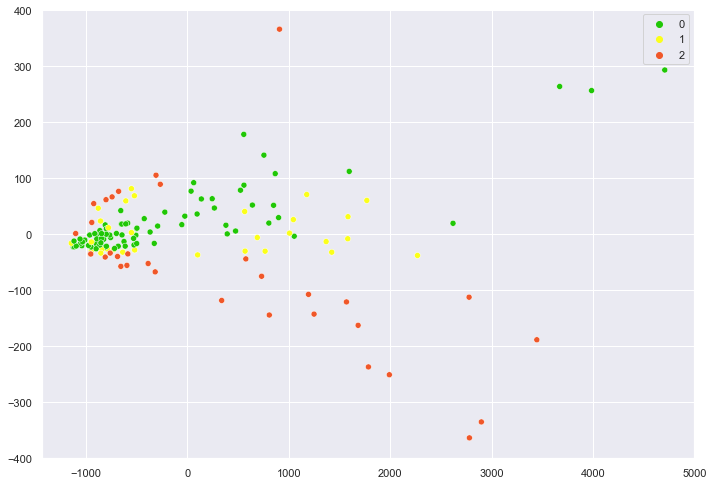

In [567]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

X_embedded = Isomap(n_components = 2, n_neighbors = 40, eigen_solver = 'auto').fit_transform(dat_volume)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = num_index_3, palette = sns.color_palette(colors))

In [568]:
total_metrics_kernel_isomap = calc_metrics(X_embedded)
total_metrics_kernel_isomap

Knn is ready
logred is ready
rnd_for is ready
des_tree is ready
lin_svc is ready
gnb is ready
lda is ready
cat is ready
mlp is ready


,accur,recall,precis,f1,roc_auc
KNN,0.659091,0.497778,0.644444,0.507716,0.681296
LogReg,0.659091,0.466667,0.541667,0.446886,0.758889
RandFor,0.863636,0.785185,0.887356,0.813404,0.878778
DecTree,0.772727,0.688148,0.723545,0.701589,0.758852
SVC,0.659091,0.466667,0.541667,0.446886,0.671296
GausNB,0.636364,0.453333,0.471795,0.427778,0.777852
LDA,0.659091,0.466667,0.541667,0.446886,0.789259
CatBoostClassifier,0.840909,0.748148,0.877778,0.774825,0.861778
MLPClassifier,0.636364,0.533333,0.411111,0.449887,0.812074


<AxesSubplot:xlabel='roc_auc'>

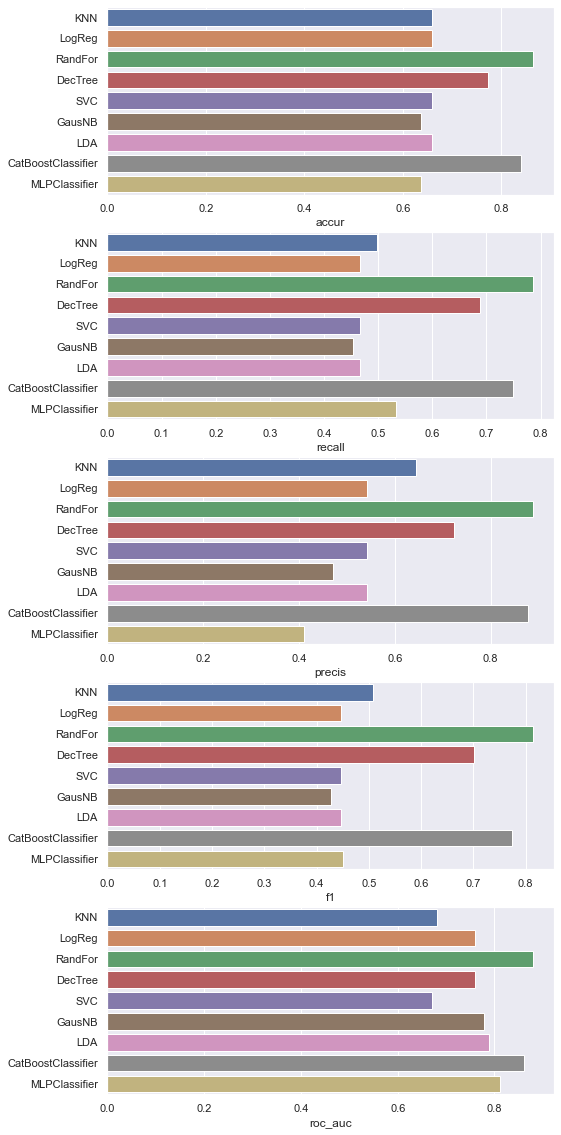

In [569]:
#графики accur recall precis f1 roc_auc

sns.set(rc={'figure.figsize':(8,20)})
fig, ax = plt.subplots(5,1)
sns.barplot(x="accur", y = total_metrics_kernel_isomap.index, data=total_metrics_kernel_isomap, ax = ax[0])
sns.barplot(x="recall", y = total_metrics_kernel_isomap.index, data=total_metrics_kernel_isomap, ax = ax[1])
sns.barplot(x="precis", y = total_metrics_kernel_isomap.index, data=total_metrics_kernel_isomap, ax = ax[2])
sns.barplot(x="f1", y = total_metrics_kernel_isomap.index, data=total_metrics_kernel_isomap, ax = ax[3])
sns.barplot(x="roc_auc", y = total_metrics_kernel_isomap.index, data=total_metrics_kernel_isomap, ax = ax[4])

### ISOMAP 50 соседей

<AxesSubplot:>

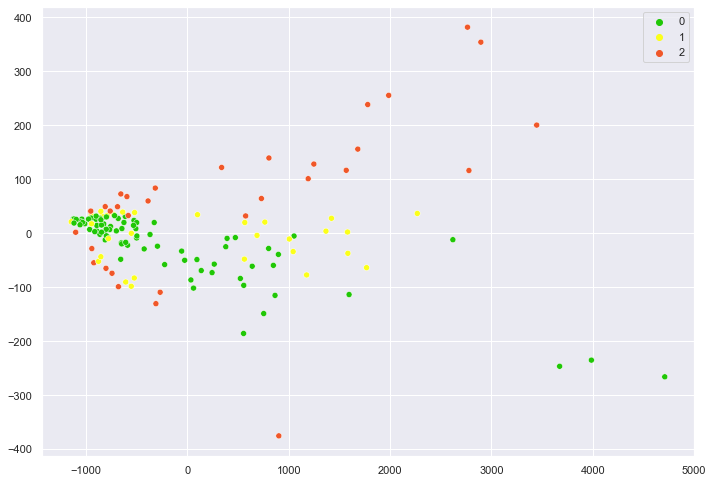

In [570]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

X_embedded = Isomap(n_components = 2, n_neighbors = 50, eigen_solver = 'auto').fit_transform(dat_volume)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = num_index_3, palette = sns.color_palette(colors))

In [571]:
total_metrics_kernel_isomap_50 = calc_metrics(X_embedded)
total_metrics_kernel_isomap_50

Knn is ready
logred is ready
rnd_for is ready
des_tree is ready
lin_svc is ready
gnb is ready
lda is ready
cat is ready
mlp is ready


,accur,recall,precis,f1,roc_auc
KNN,0.659091,0.497778,0.644444,0.507716,0.667185
LogReg,0.659091,0.466667,0.541667,0.446886,0.747778
RandFor,0.795455,0.701481,0.780556,0.727946,0.803407
DecTree,0.772727,0.711852,0.739198,0.723744,0.764704
SVC,0.636364,0.433333,0.536585,0.406371,0.658333
GausNB,0.636364,0.453333,0.471795,0.427778,0.821778
LDA,0.636364,0.433333,0.536585,0.406371,0.781407
CatBoostClassifier,0.818182,0.714815,0.827151,0.747354,0.852741
MLPClassifier,0.727273,0.665185,0.689815,0.675836,0.774667


<AxesSubplot:xlabel='roc_auc'>

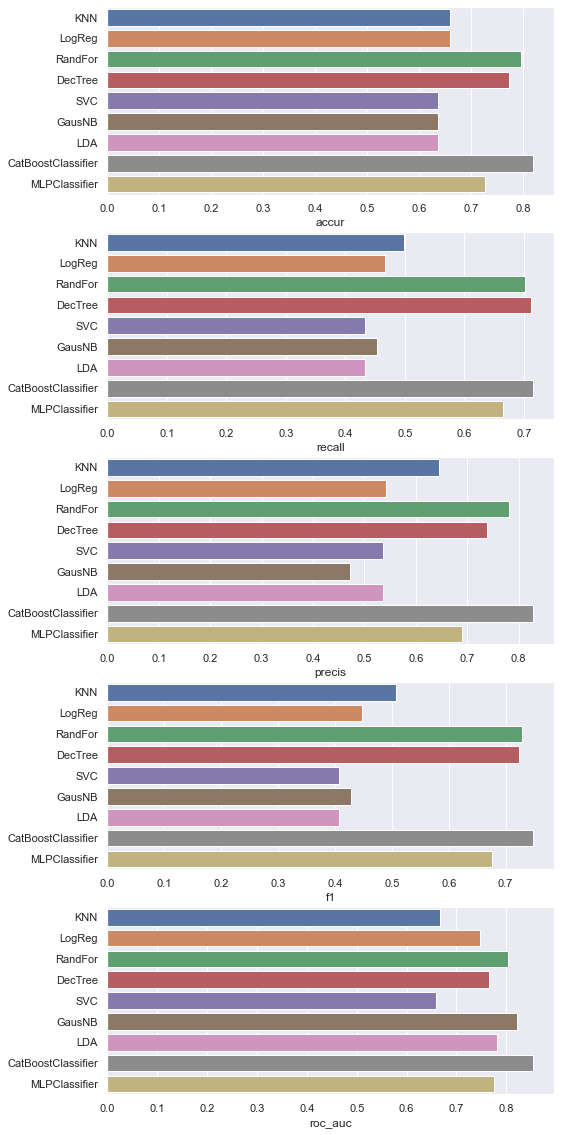

In [572]:
#графики accur recall precis f1 roc_auc

sns.set(rc={'figure.figsize':(8,20)})
fig, ax = plt.subplots(5,1)
sns.barplot(x="accur", y = total_metrics_kernel_isomap_50.index, data=total_metrics_kernel_isomap_50, ax = ax[0])
sns.barplot(x="recall", y = total_metrics_kernel_isomap_50.index, data=total_metrics_kernel_isomap_50, ax = ax[1])
sns.barplot(x="precis", y = total_metrics_kernel_isomap_50.index, data=total_metrics_kernel_isomap_50, ax = ax[2])
sns.barplot(x="f1", y = total_metrics_kernel_isomap_50.index, data=total_metrics_kernel_isomap_50, ax = ax[3])
sns.barplot(x="roc_auc", y = total_metrics_kernel_isomap_50.index, data=total_metrics_kernel_isomap_50, ax = ax[4])

### TSNE

In [573]:
from sklearn.manifold import TSNE

In [613]:
score = []

for rate in range(5, 100, 5):
    for perp in range(5, 80, 5):
        X_embedded = TSNE(n_components=2, learning_rate=rate, init='random', random_state = 0, perplexity = perp).fit_transform(dat_volume)
        X_train, X_test, y_train, y_test = train_test_split(X_embedded, num_index_3, stratify=num_index_3, test_size = 0.2, random_state = 0)
        knn = KNeighborsClassifier(n_neighbors=4)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        score.append([accuracy_score(y_test, y_pred), rate, perp])

In [614]:
score.sort()
print(score[-1])
learning_rate = score[-1][1]
perplexity = score[-1][2]

[0.5862068965517241, 95, 75]


<AxesSubplot:>

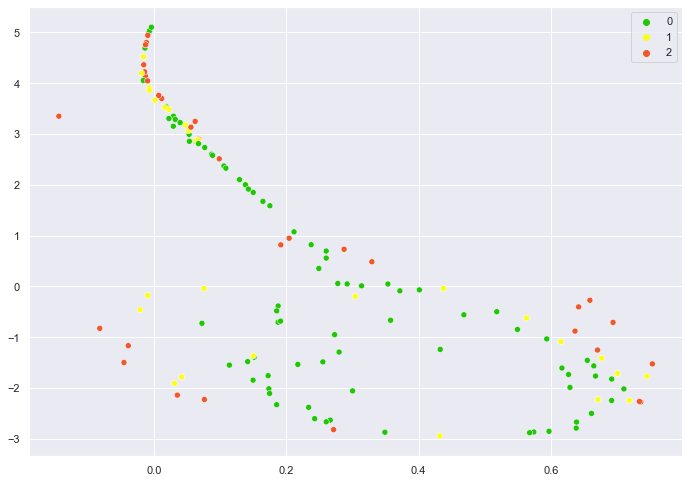

In [615]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

X_embedded = TSNE(n_components=2, learning_rate=learning_rate, init='random', random_state = 0, perplexity = perplexity).fit_transform(dat_volume)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = num_index_3, palette = sns.color_palette(colors))

In [577]:
total_metrics_tsne = calc_metrics(X_embedded)
total_metrics_tsne

Knn is ready
logred is ready
rnd_for is ready
des_tree is ready
lin_svc is ready
gnb is ready
lda is ready
cat is ready
mlp is ready


,accur,recall,precis,f1,roc_auc
KNN,0.636364,0.440741,0.713675,0.423587,0.602333
LogReg,0.568182,0.333333,0.189394,0.241546,0.602000
RandFor,0.590909,0.406667,0.350490,0.370998,0.699852
DecTree,0.613636,0.420000,0.377193,0.378968,0.573704
SVC,0.568182,0.333333,0.189394,0.241546,0.489667
GausNB,0.613636,0.420000,0.450000,0.389011,0.652593
LDA,0.568182,0.333333,0.189394,0.241546,0.604593
CatBoostClassifier,0.636364,0.453333,0.432900,0.432725,0.667704
MLPClassifier,0.568182,0.333333,0.189394,0.241546,0.574148


<AxesSubplot:xlabel='roc_auc'>

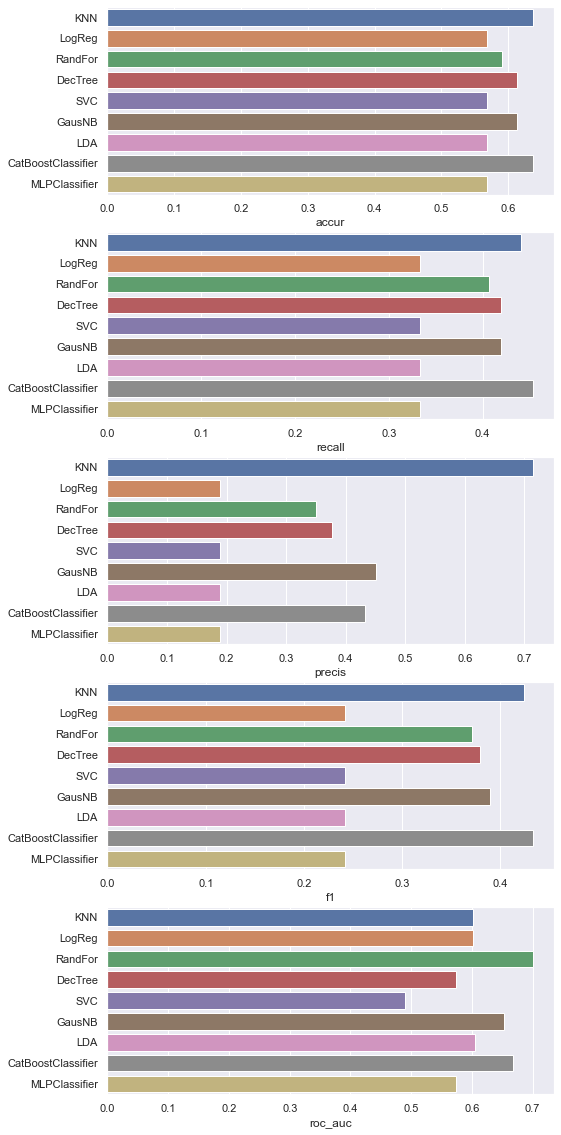

In [578]:
#графики accur recall precis f1 roc_auc

sns.set(rc={'figure.figsize':(8,20)})
fig, ax = plt.subplots(5,1)
sns.barplot(x="accur", y = total_metrics_tsne.index, data=total_metrics_tsne, ax = ax[0])
sns.barplot(x="recall", y = total_metrics_tsne.index, data=total_metrics_tsne, ax = ax[1])
sns.barplot(x="precis", y = total_metrics_tsne.index, data=total_metrics_tsne, ax = ax[2])
sns.barplot(x="f1", y = total_metrics_tsne.index, data=total_metrics_tsne, ax = ax[3])
sns.barplot(x="roc_auc", y = total_metrics_tsne.index, data=total_metrics_tsne, ax = ax[4])

### TSNE с другими параметрами

<AxesSubplot:>

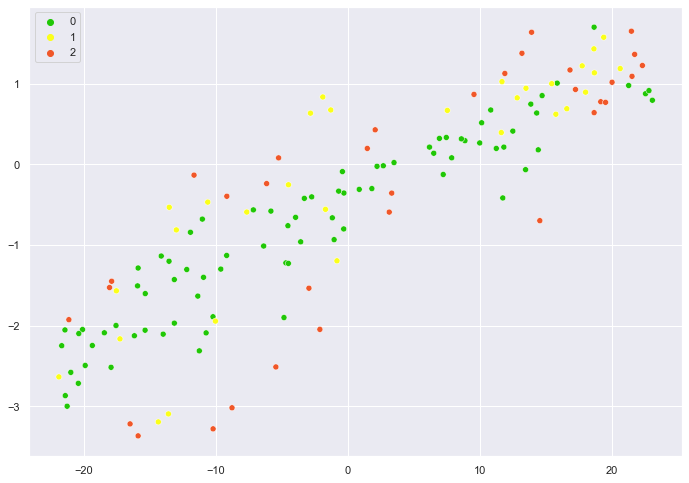

In [579]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

X_embedded = TSNE(n_components=2, learning_rate=30, init='random', random_state = 0, perplexity = 20).fit_transform(dat_volume)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = num_index_3, palette = sns.color_palette(colors))

In [580]:
total_metrics_tsne_2 = calc_metrics(X_embedded)
total_metrics_tsne_2

Knn is ready
logred is ready
rnd_for is ready
des_tree is ready
lin_svc is ready
gnb is ready
lda is ready
cat is ready
mlp is ready


,accur,recall,precis,f1,roc_auc
KNN,0.659091,0.474074,0.769231,0.482639,0.645481
LogReg,0.590909,0.366667,0.527132,0.305704,0.628963
RandFor,0.659091,0.497778,0.600373,0.498751,0.689000
DecTree,0.590909,0.434074,0.457738,0.430979,0.558963
SVC,0.568182,0.333333,0.189394,0.241546,0.515000
GausNB,0.568182,0.357037,0.266082,0.298413,0.601704
LDA,0.590909,0.366667,0.527132,0.305704,0.630148
CatBoostClassifier,0.659091,0.494074,0.596405,0.502932,0.658963
MLPClassifier,0.659091,0.474074,0.571429,0.469231,0.666148


<AxesSubplot:xlabel='roc_auc'>

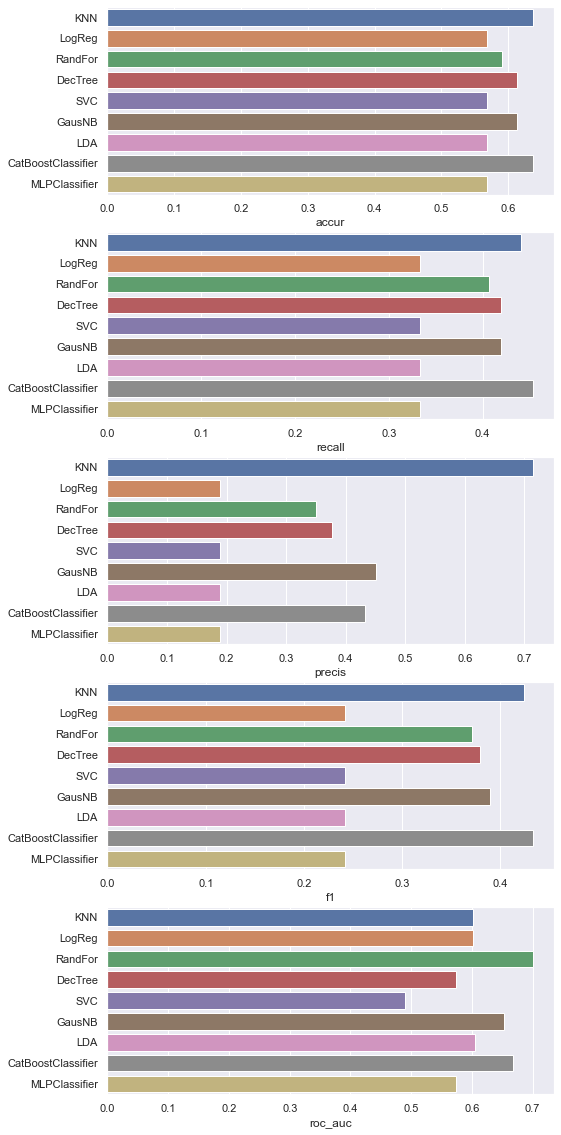

In [581]:
#графики accur recall precis f1 roc_auc

sns.set(rc={'figure.figsize':(8,20)})
fig, ax = plt.subplots(5,1)
sns.barplot(x="accur", y = total_metrics_tsne.index, data=total_metrics_tsne, ax = ax[0])
sns.barplot(x="recall", y = total_metrics_tsne.index, data=total_metrics_tsne, ax = ax[1])
sns.barplot(x="precis", y = total_metrics_tsne.index, data=total_metrics_tsne, ax = ax[2])
sns.barplot(x="f1", y = total_metrics_tsne.index, data=total_metrics_tsne, ax = ax[3])
sns.barplot(x="roc_auc", y = total_metrics_tsne.index, data=total_metrics_tsne, ax = ax[4])

### PLSCanonical

In [582]:
from sklearn.cross_decomposition import PLSCanonical

In [583]:
y_axis = []

for i in num_index_3:
    if i == 0:
        y_axis.append([1, 1])
    elif i == 1:
        y_axis.append([-1, 1])
    elif i == 2:
        y_axis.append([-1, -1])

<AxesSubplot:>

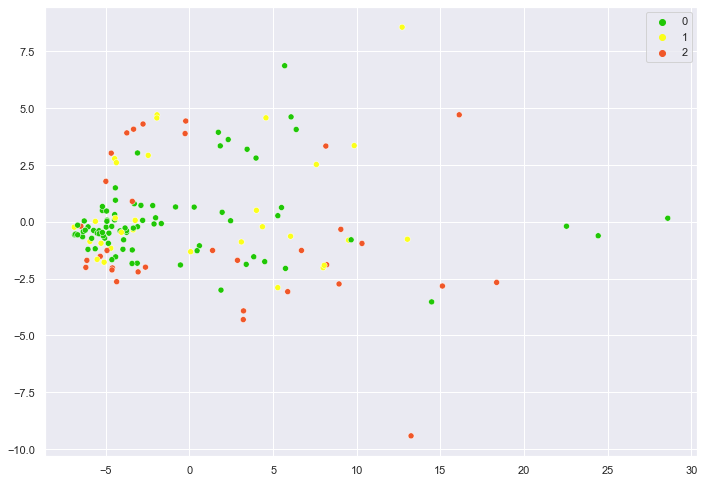

In [584]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

X_c, y_c = PLSCanonical(n_components = 2).fit_transform(dat_volume, y_axis)
sns.scatterplot(X_c[:,0], X_c[:,1], hue = num_index_3, palette = sns.color_palette(colors))

In [585]:
total_metrics_pls = calc_metrics(X_c)
total_metrics_pls

Knn is ready
logred is ready
rnd_for is ready
des_tree is ready
lin_svc is ready
gnb is ready
lda is ready
cat is ready
mlp is ready


,accur,recall,precis,f1,roc_auc
KNN,0.590909,0.406667,0.355820,0.369013,0.648667
LogReg,0.568182,0.333333,0.189394,0.241546,0.572815
RandFor,0.613636,0.460000,0.395833,0.423977,0.672741
DecTree,0.545455,0.380000,0.323232,0.346642,0.586889
SVC,0.568182,0.333333,0.189394,0.241546,0.522000
GausNB,0.590909,0.406667,0.535088,0.397232,0.680370
LDA,0.545455,0.320000,0.186047,0.235294,0.567111
CatBoostClassifier,0.704545,0.557037,0.616667,0.541308,0.621556
MLPClassifier,0.568182,0.353333,0.288462,0.297619,0.627037


<AxesSubplot:xlabel='roc_auc'>

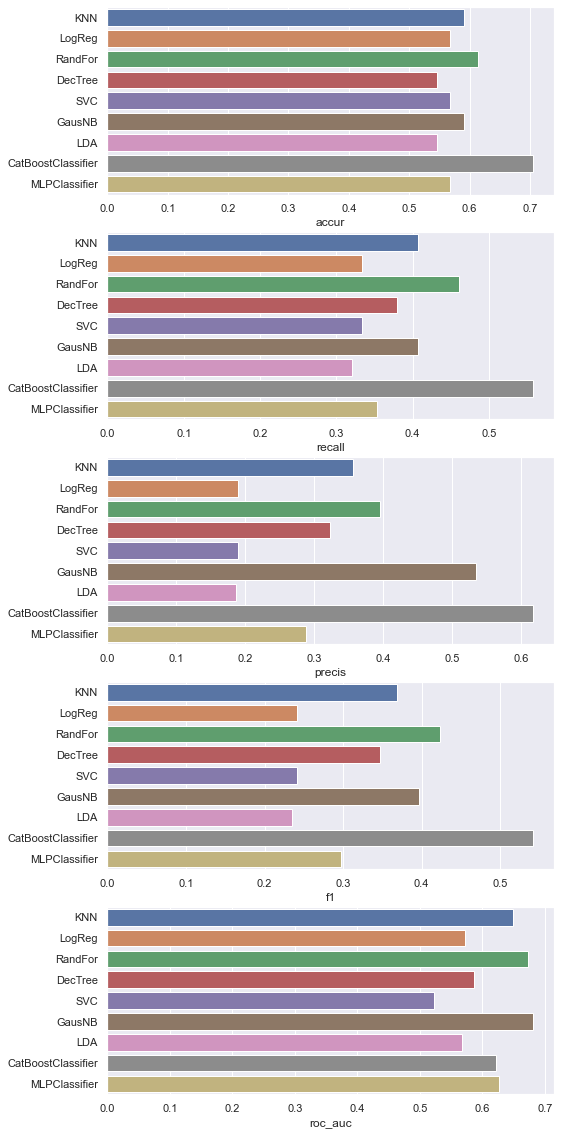

In [586]:
#графики accur recall precis f1 roc_auc

sns.set(rc={'figure.figsize':(8,20)})
fig, ax = plt.subplots(5,1)
sns.barplot(x="accur", y = total_metrics_pls.index, data=total_metrics_pls, ax = ax[0])
sns.barplot(x="recall", y = total_metrics_pls.index, data=total_metrics_pls, ax = ax[1])
sns.barplot(x="precis", y = total_metrics_pls.index, data=total_metrics_pls, ax = ax[2])
sns.barplot(x="f1", y = total_metrics_pls.index, data=total_metrics_pls, ax = ax[3])
sns.barplot(x="roc_auc", y = total_metrics_pls.index, data=total_metrics_pls, ax = ax[4])

### UMAP

In [587]:
import umap

In [588]:
score = []

for i in range(5, 60, 5):
    n_neighbors = i
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.6, n_components=2, metric='euclidean', random_state = 0)
    embedding = reducer.fit_transform(dat_volume)
    
    X_train, X_test, y_train, y_test = train_test_split(embedding, num_index_3, stratify=num_index_3, test_size = 0.2, random_state = 0)
    knn = KNeighborsClassifier(n_neighbors=4)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score.append([accuracy_score(y_test, y_pred), i])    

In [589]:
score.sort()
print(score[-1])
n_neighbors = score[-1][1]

[0.6206896551724138, 50]


<AxesSubplot:>

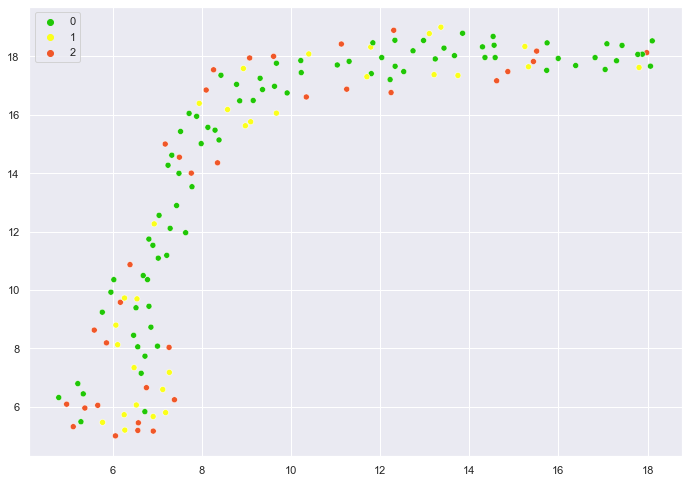

In [590]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.6, n_components=2, metric='euclidean', random_state = 0)
embedding = reducer.fit_transform(dat_volume)
sns.scatterplot(embedding[:,0], embedding[:,1], hue = num_index_3, palette = sns.color_palette(colors))

In [591]:
total_metrics_umap = calc_metrics(embedding)
total_metrics_umap

Knn is ready
logred is ready
rnd_for is ready
des_tree is ready
lin_svc is ready
gnb is ready
lda is ready
cat is ready
mlp is ready


,accur,recall,precis,f1,roc_auc
KNN,0.636364,0.440741,0.503003,0.422663,0.574667
LogReg,0.568182,0.333333,0.189394,0.241546,0.614593
RandFor,0.590909,0.370370,0.527132,0.311765,0.484741
DecTree,0.568182,0.373333,0.302445,0.325743,0.494222
SVC,0.568182,0.333333,0.189394,0.241546,0.603481
GausNB,0.613636,0.420000,0.359073,0.375712,0.634963
LDA,0.568182,0.333333,0.189394,0.241546,0.615037
CatBoostClassifier,0.545455,0.414815,0.362745,0.382851,0.520000
MLPClassifier,0.613636,0.400000,0.375000,0.351648,0.604148


<AxesSubplot:xlabel='roc_auc'>

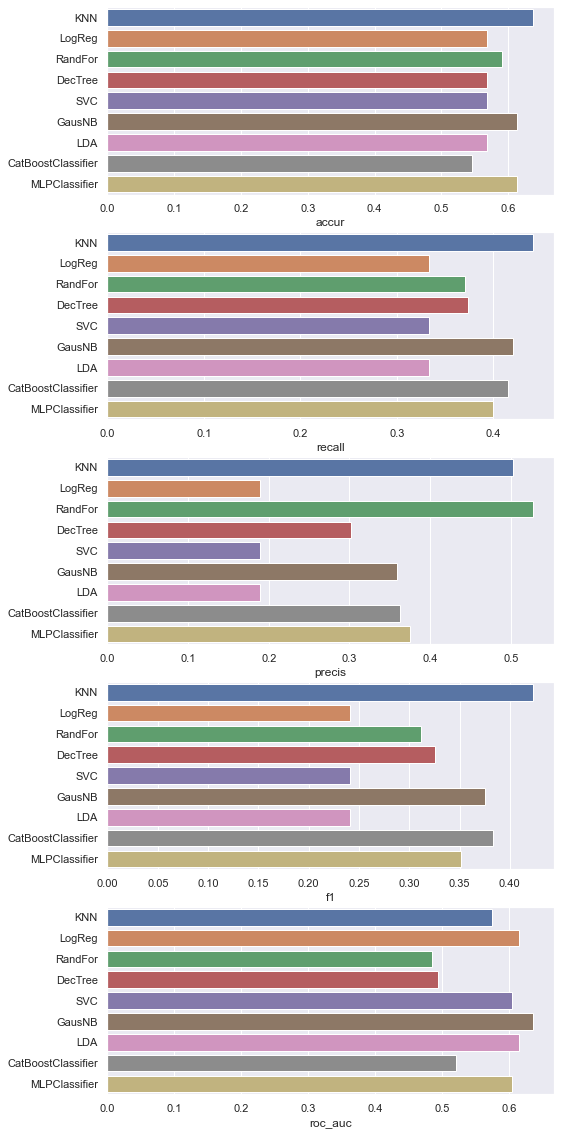

In [592]:
#графики accur recall precis f1 roc_auc

sns.set(rc={'figure.figsize':(8,20)})
fig, ax = plt.subplots(5,1)
sns.barplot(x="accur", y = total_metrics_umap.index, data=total_metrics_umap, ax = ax[0])
sns.barplot(x="recall", y = total_metrics_umap.index, data=total_metrics_umap, ax = ax[1])
sns.barplot(x="precis", y = total_metrics_umap.index, data=total_metrics_umap, ax = ax[2])
sns.barplot(x="f1", y = total_metrics_umap.index, data=total_metrics_umap, ax = ax[3])
sns.barplot(x="roc_auc", y = total_metrics_umap.index, data=total_metrics_umap, ax = ax[4])

### LocallyLinearEmbedding

In [593]:
from sklearn.manifold import LocallyLinearEmbedding

<AxesSubplot:>

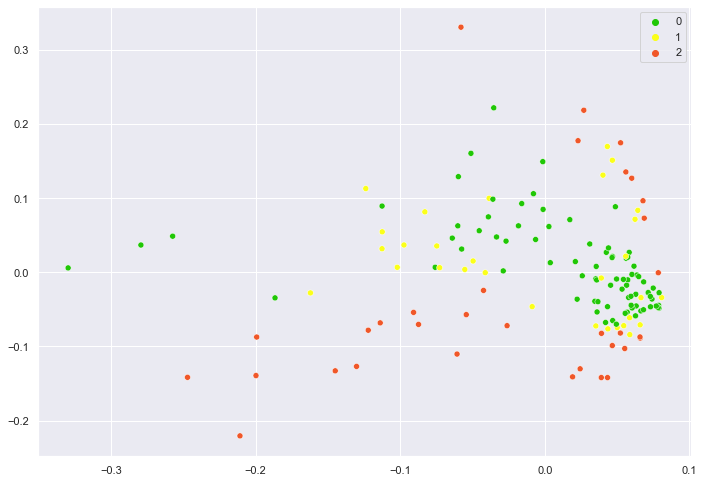

In [594]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

X_embedded = LocallyLinearEmbedding(method = 'standard', n_components = 2, n_neighbors = 60, eigen_solver = 'auto', random_state = 0).fit_transform(dat_volume)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue = num_index_3, palette = sns.color_palette(colors))

In [595]:
total_metrics_lle = calc_metrics(X_embedded)
total_metrics_lle

Knn is ready
logred is ready
rnd_for is ready
des_tree is ready
lin_svc is ready
gnb is ready
lda is ready
cat is ready
mlp is ready


,accur,recall,precis,f1,roc_auc
KNN,0.818182,0.714815,0.860417,0.757384,0.848000
LogReg,0.568182,0.333333,0.189394,0.241546,0.712815
RandFor,0.772727,0.664444,0.749731,0.687831,0.761889
DecTree,0.704545,0.577037,0.635101,0.579183,0.774852
SVC,0.590909,0.366667,0.527132,0.305704,0.615481
GausNB,0.636364,0.453333,0.471795,0.427778,0.792148
LDA,0.613636,0.400000,0.531746,0.359867,0.742000
CatBoostClassifier,0.772727,0.664444,0.749731,0.687831,0.823481
MLPClassifier,0.568182,0.333333,0.189394,0.241546,0.662000


<AxesSubplot:xlabel='roc_auc'>

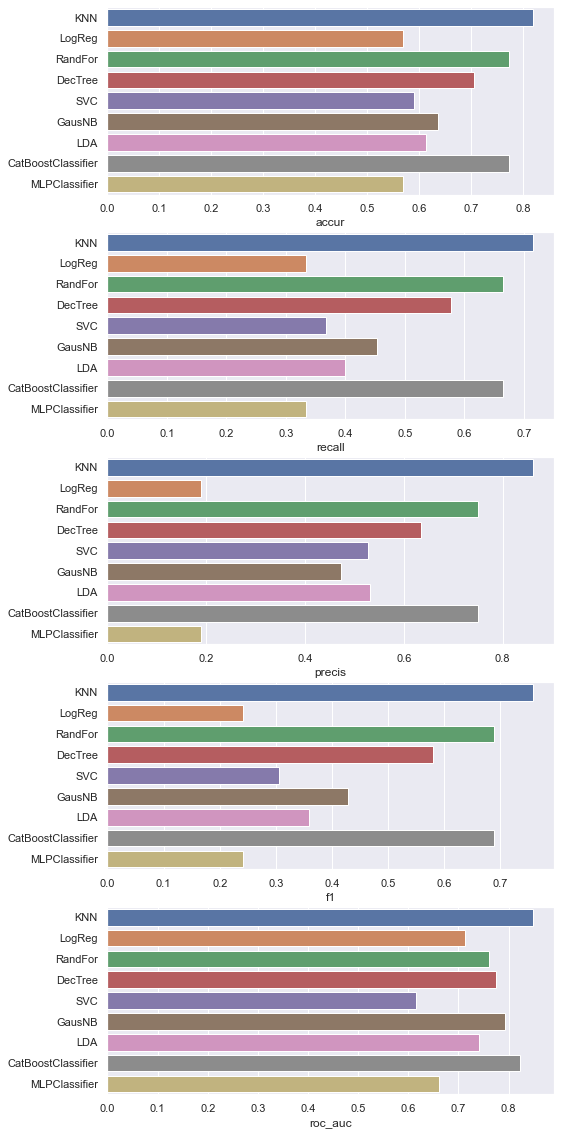

In [596]:
#графики accur recall precis f1 roc_auc

sns.set(rc={'figure.figsize':(8,20)})
fig, ax = plt.subplots(5,1)
sns.barplot(x="accur", y = total_metrics_lle.index, data=total_metrics_lle, ax = ax[0])
sns.barplot(x="recall", y = total_metrics_lle.index, data=total_metrics_lle, ax = ax[1])
sns.barplot(x="precis", y = total_metrics_lle.index, data=total_metrics_lle, ax = ax[2])
sns.barplot(x="f1", y = total_metrics_lle.index, data=total_metrics_lle, ax = ax[3])
sns.barplot(x="roc_auc", y = total_metrics_lle.index, data=total_metrics_lle, ax = ax[4])